<a href="https://colab.research.google.com/github/DFwJZ/Real-time_Bot_Detection/blob/main/Cresci2017_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk

In [ ]:
!pip install tqdm

In [ ]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import tqdm
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Process genuine and fake data separately

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2017"

In [ ]:
# Jason's file path
root_path = "/content/drive/MyDrive/Colab Notebooks/Summer_Camp/Bot_detection/cresci tweets/cresci 2017"

In [ ]:
# Genuine Data Read in
try:
    df_genuine_data = pd.read_csv(f'{root_path}/genuine_tweets.csv',encoding = 'latin_1')
    print("Data loaded successfully with 'latin_1' encoding.")
except Exception as e:
    print("Error while reading the CSV file:", e)

<ipython-input-20-6460d800ed46>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_genuine_data = pd.read_csv(f'{root_path}/genuine_tweets.csv',encoding = 'latin_1')


Data loaded successfully with 'latin_1' encoding.


In [ ]:
df_genuine_data.shape

(2839362, 25)

In [ ]:
expected_columns_genuine = df_genuine_data.columns.tolist()
expected_columns_genuine

['id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'contributors',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'created_at',
 'timestamp',
 'crawled_at',
 'updated']

In [ ]:
# Calculate the number of unique ids
num_unique_ids = df_genuine_data['user_id'].nunique()

num_unique_ids

1083

In [ ]:
# Read fake data
fake_data_file =['2017_fake_followers_tweets.csv', '2017_spam1_tweets.csv', '2017_social1_tweets.csv', '2017_social2_tweets.csv', '2017_social3_tweets.csv']

df_fake_combined = pd.DataFrame()
common_columns = None

# Load the fake data
for file in fake_data_file:
    try:
        df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')

        if df_fake_combined.empty:
            # This is the first file - initialize df_combined and common_columns
            df_fake_combined = df
            common_columns = set(df.columns)
        else:
            # This is a subsequent file - update common_columns and append only common columns to df_combined
            common_columns &= set(df.columns)
            df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])

        print(f"{file} loaded successfully with 'latin_1' encoding.")
    except Exception as e:
        print(f"Error while reading the {file} CSV file:", e)

<ipython-input-24-b1dd6727acc3>:10: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')


2017_fake_followers_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-24-b1dd6727acc3>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


2017_spam1_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-24-b1dd6727acc3>:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')
<ipython-input-24-b1dd6727acc3>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


2017_social1_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-24-b1dd6727acc3>:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')
<ipython-input-24-b1dd6727acc3>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


2017_social2_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-24-b1dd6727acc3>:10: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')
<ipython-input-24-b1dd6727acc3>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


2017_social3_tweets.csv loaded successfully with 'latin_1' encoding.


In [ ]:
df_fake_combined.shape

(3798254, 23)

In [ ]:
expected_columns_fake= df_fake_combined.columns.tolist()
expected_columns_fake

['created_at',
 'id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'contributors',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'timestamp']

In [ ]:
mismatched_columns = list(set(expected_columns_genuine) - set(expected_columns_fake))
mismatched_columns

['crawled_at', 'updated']

In [ ]:
# Drop unmatched columns
df_genuine_data.drop(mismatched_columns, axis=1, inplace=True)

In [ ]:
# Check unmatched columns again
expected_columns_genuine_2nd = df_genuine_data.columns.tolist()

mismatched_columns_2nd = list(set(expected_columns_genuine_2nd) - set(expected_columns_fake))
mismatched_columns_2nd

[]

In [ ]:
df_genuine_data_20k_seg = df_genuine_data.head(20000)

In [ ]:
df_fake_data_20k_seg = df_fake_combined.head(20000)

In [ ]:
df_genuine_subset_name = f'{root_path}/df_genuine_data_20k_seg.csv'

try:
  if os.path.exists(df_genuine_subset_name):
    os.remove(df_genuine_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

df_genuine_data_20k_seg.to_csv(df_genuine_subset_name, index=False)

In [ ]:
df_fake_subset_name = f'{root_path}/df_fake_data_20k_seg.csv'

try:
  if os.path.exists(df_fake_subset_name):
    os.remove(df_genuine_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

df_genuine_data_20k_seg.to_csv(df_fake_subset_name, index=False)

In [ ]:
!pip install hydra-core

In [ ]:
!pip install transformers

In [ ]:
import transformers as ppb
import torch
import numpy as np

In [ ]:
class DistilBERT:
    def __init__(self):
        """ Initialize Distil-BERT model

        Args:
            param: distil-bert parameters from hydra config
        """
        self.model_class = ppb.DistilBertModel
        self.tokenizer_class = ppb.DistilBertTokenizer

        self.tokenizer = self.tokenizer_class.from_pretrained(
            #self.param.pretrained_weights
            'distilbert-base-uncased'
        )
        self.model = self.model_class.from_pretrained(
            #self.param.pretrained_weights
            'distilbert-base-uncased'
        )

    def embed(self, sample):
        tokens = self.tokenizer(
            sample, add_special_tokens=True, padding=True, truncation=True,
            #max_length=self.param.max_tokens, return_tensors='pt')
            max_length= 400, return_tensors='pt')

        with torch.no_grad():
            last_hidden_states = self.model(
                tokens['input_ids'], attention_mask=tokens['attention_mask']
            )

        features = last_hidden_states[0][:, 0, :].numpy()
        return features



distil_bert = DistilBERT()
print("Success!") if distil_bert else print("Fail!")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Success!


In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
class DistilBERT:
    def __init__(self, batch_size=16):
        """ Initialize Distil-BERT model """
        self.model_name = 'distilbert-base-uncased'
        self.model_class = DistilBertModel
        self.tokenizer_class = DistilBertTokenizer

        self.tokenizer = self.tokenizer_class.from_pretrained(self.model_name)
        self.model = self.model_class.from_pretrained(self.model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        self.batch_size=batch_size

    def embed(self, samples):
        n = len(samples)
        features = []

        for i in range(0, n, self.batch_size):
            batch = samples[i:i+self.batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            encoded_input = {key: value.to(self.device) for key, value in encoded_input.items()}

            with torch.no_grad():
                last_hidden_states = self.model(**encoded_input)

            batch_features = last_hidden_states.last_hidden_state[:, 0, :].cpu().numpy()
            features.extend(batch_features)

        return np.array(features)

# Test the modified class
distil_bert = DistilBERT()
print("Success!") if distil_bert else print("Fail!")


In [ ]:
# tqdm library is used to display the process bar, easy to track the process when running in backgroud
tqdm.tqdm.pandas(mininterval=1)

In [ ]:
from nltk.tokenize import TweetTokenizer

# Create an instance of the TweetTokenizer
tokenizer = TweetTokenizer()

# Define the function for text preprocessing
def preprocess_text(text):
    # Lowercase the letters
    text = str(text)
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Tokenize the text using the TweetTokenizer
    tokens = tokenizer.tokenize(text)

    # Remove punctuations
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stopword = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopword]

    # Lemmatization
    wn = WordNetLemmatizer()
    tokens = [wn.lemmatize(token, 'v') for token in tokens]

    # Join the tokens back into text
    processed_text = " ".join(tokens)

    return processed_text

In [ ]:
data_g = df_genuine_data_20k_seg.dropna(subset=['text'])

In [ ]:
data_f = df_fake_data_20k_seg.dropna(subset=['text'])

In [ ]:
# Apply the function to the 'text' column of the genuine DataFrame
data_g['preprocessed_text'] = data_g['text'].progress_apply(preprocess_text)

data_g.head()

In [ ]:
# Apply the function to the 'text' column of the genuine DataFrame
data_f['preprocessed_text'] = data_f['text'].progress_apply(preprocess_text)

data_f.head()

In [ ]:
data_g['embedded_features'] = data_g['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))
data_f['embedded_features'] = data_f['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))

100%|██████████| 19997/19997 [08:26<00:00, 39.46it/s]
<ipython-input-66-18eeffc793da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_g['embedded_features'] = data_g['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))
100%|██████████| 19994/19994 [11:50<00:00, 28.12it/s]
<ipython-input-66-18eeffc793da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f['embedded_features'] = data_f['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))


In [ ]:
data_g['text']

0        RT @morningJewshow: Speaking about Jews and co...
1        This age/face recognition thing..no reason pla...
2        Only upside of the moment I can think of is th...
3        If you're going to think about+create experien...
4        Watching a thread on FB about possible future ...
                               ...                        
19995        @stevekovach phone numbers are recycled a lot
19996    @kittukolluri @nntaleb "rich is he who has all...
19997    Gracias!! â@LuisGyG: "Addappt: la agenda int...
19998               @jyarow it better be world changing ..
19999    addappt on @36kr - LinkedInæ©æåå·¥åäºä...
Name: text, Length: 19997, dtype: object

In [ ]:
data_g['preprocessed_text']

0        rt speak jews comedy tonight temple emanu-el s...
1        age face recognition thing .. reason platforms...
2        upside moment think network news book #baltimo...
3        go think create experience need broad knowledg...
4        watch thread fb possible future ux speaker cro...
                               ...                        
19995                             phone number recycle lot
19996                                 rich money can't buy
19997    gracias addappt la agenda inteligente para tu ...
19998                               better world change ..
19999    addappt linkedinæ  © æ   å   å · ¥ å   ...
Name: preprocessed_text, Length: 19997, dtype: object

In [ ]:
# Create lists to store the embeddings
genuine_embeddings = []
fake_embeddings = []

# Generate embeddings for each text entry in the genuine DataFrame
for text in tqdm.tqdm(data_g['preprocessed_text'], total=len(data_g)):
    embedding = distil_bert.embed([text])  # embed expects a list of texts
    genuine_embeddings.append(embedding)

# Generate embeddings for each text entry in the fake DataFrame
for text in tqdm.tqdm(data_f['preprocessed_text'], total=len(data_f)):
    embedding = distil_bert.embed([text])  # embed expects a list of texts
    fake_embeddings.append(embedding)

# Convert the lists to numpy arrays
genuine_embeddings = np.array(genuine_embeddings)
fake_embeddings = np.array(fake_embeddings)

# Save the embeddings
np.save(f'{root_path}/genuine_embeddings_20k.npy', genuine_embeddings)
np.save(f'{root_path}/fake_embeddings_20k.npy', fake_embeddings)


In [ ]:
df_genuine_subset_processed = f'{root_path}/df_genuine_20k_processed.csv'

try:
  if os.path.exists(df_genuine_subset_processed):
    os.remove(df_genuine_subset_processed)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_g.to_csv(df_genuine_subset_processed, index=False)

In [ ]:
df_fake_subset_processed = f'{root_path}/df_fake_20k_processed.csv'

try:
  if os.path.exists(df_fake_subset_processed):
    os.remove(df_fake_subset_processed)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_f.to_csv(df_fake_subset_processed, index=False)

In [ ]:
# Tokenize words without further proprocessing them
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

genuine_embeddings_20k_no_preprocessing = []
fake_embeddings_20k_no_preprocessing = []

genuine_tokenized_text_20k_no_preprocessing = []
fake_tokenized_text_20k_no_preprocessing = []

for text in tqdm.tqdm(data_g['text'], total=len(data_g)):
    # Tokenize the text using TweetTokenizer
    tokens = tweet_tokenizer.tokenize(text)
    genuine_tokenized_text_20k_no_preprocessing.append(tokens)

    embedding = distil_bert.embed([text])
    genuine_embeddings_20k_no_preprocessing.append(embedding)

for text in tqdm.tqdm(data_f['text'], total=len(data_f)):
    tokens = tweet_tokenizer.tokenize(text)
    fake_tokenized_text_20k_no_preprocessing.append(tokens)

    embedding = distil_bert.embed([text])
    fake_embeddings_20k_no_preprocessing.append(embedding)

genuine_embeddings = np.array(genuine_embeddings_20k_no_preprocessing)
fake_embeddings = np.array(fake_embeddings_20k_no_preprocessing)

np.save(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', genuine_embeddings)
np.save(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', fake_embeddings)


100%|██████████| 19994/19994 [02:51<00:00, 116.60it/s]


In [ ]:
genuine_embeddings = np.load(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', allow_pickle=True)
fake_embeddings = np.load(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', allow_pickle=True)

genuine_embeddings.shape, fake_embeddings.shape

((19997, 1, 768), (19994, 1, 768))

In [ ]:
from sklearn.cluster import KMeans

# Flatten the embeddings
genuine_embeddings_flat = genuine_embeddings.reshape(genuine_embeddings.shape[0], -1)
fake_embeddings_flat = fake_embeddings.reshape(fake_embeddings.shape[0], -1)

all_embeddings = np.concatenate([genuine_embeddings_flat, fake_embeddings_flat])

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_embeddings)

cluster_labels = kmeans.labels_

genuine_cluster_labels = cluster_labels[:len(genuine_embeddings_flat)]
fake_cluster_labels = cluster_labels[len(genuine_embeddings_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels == 1)
fake_cluster_0 = np.mean(fake_cluster_labels == 0)
fake_cluster_1 = np.mean(fake_cluster_labels == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.049707456118417766,
 0.9502925438815822,
 0.36110833249974994,
 0.6388916675002501)

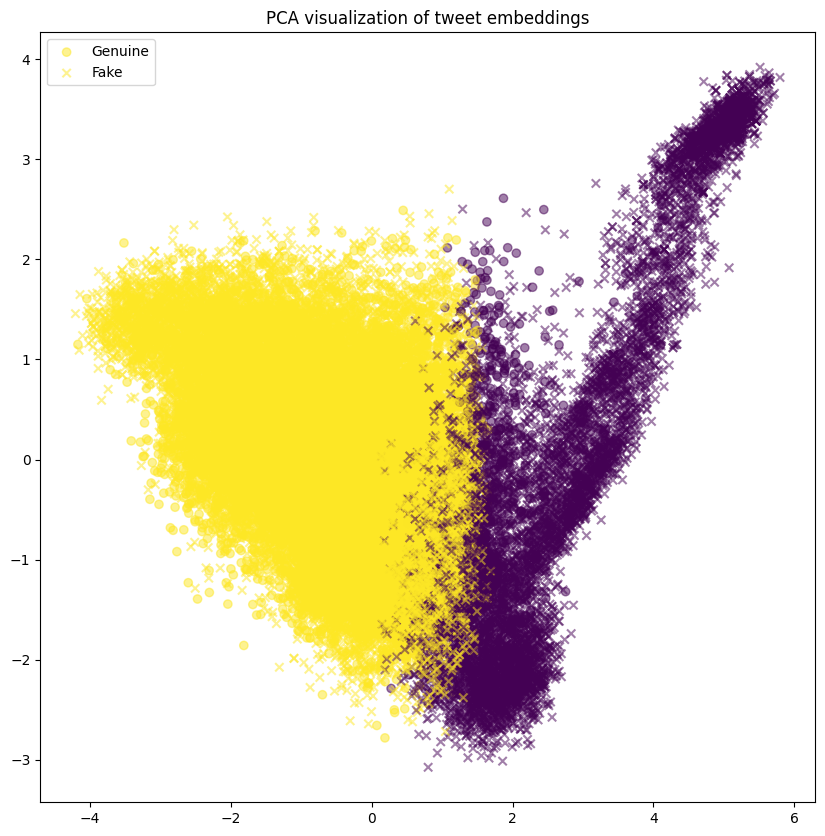

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embeddings_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 10))

plt.scatter(all_embeddings_2d[:len(genuine_embeddings_flat), 0], all_embeddings_2d[:len(genuine_embeddings_flat), 1],
            c=genuine_cluster_labels, marker='o', alpha=0.5, label='Genuine')

plt.scatter(all_embeddings_2d[len(genuine_embeddings_flat):, 0], all_embeddings_2d[len(genuine_embeddings_flat):, 1],
            c=fake_cluster_labels, marker='x', alpha=0.5, label='Fake')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score

actual_labels = np.concatenate([np.zeros(len(genuine_embeddings_flat)), np.ones(len(fake_embeddings_flat))])

conf_matrix = confusion_matrix(actual_labels, cluster_labels)

if genuine_cluster_0 > genuine_cluster_1:
    predicted_labels = cluster_labels
else:
    predicted_labels = 1 - cluster_labels
f1 = f1_score(actual_labels, predicted_labels)

silhouette = silhouette_score(all_embeddings, cluster_labels)

conf_matrix, f1, silhouette

(array([[  994, 19003],
        [ 7220, 12774]]),
 0.5119115144639819,
 0.1954)

In [ ]:
correct_classifications = np.sum(predicted_labels == actual_labels)
incorrect_classifications = np.sum(predicted_labels != actual_labels)
total_points = len(actual_labels)

correct_percentage = (correct_classifications / total_points) * 100
incorrect_percentage = (incorrect_classifications / total_points) * 100

print(f'correct: {round(correct_percentage, 2)}%\nincorrect: {round(incorrect_percentage, 2)}%')

correct: 65.57%
incorrect: 34.43%
